<a href="https://colab.research.google.com/github/haydar175/Neuromorphic-Tactile-Sensing-System-For-Textural-Features-Classification/blob/main/Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install the necessary libraries**

In [13]:
! pip install brian2
from brian2 import *
import numpy as np
import glob

**Data wull be published soon**

In [14]:
!unzip /content/data.zip -d /content

Archive:  /content/data.zip
replace /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t1.txt  
  inflating: /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t2.txt  
  inflating: /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t3.txt  
  inflating: /content/data/Text5/Texture_Text5_Sp400_Dr(x)_Fr168_t1.txt  
  inflating: /content/data/Text5/Texture_Text5_Sp400_Dr(x)_Fr168_t2.txt  
  inflating: /content/data/Text5/Texture_Text5_Sp400_Dr(x)_Fr168_t30.txt  
  inflating: /content/data/Text8/Texture_Text8_Sp400_Dr(x)_Fr168_t1.txt  
  inflating: /content/data/Text8/Texture_Text8_Sp400_Dr(x)_Fr168_t2.txt  
  inflating: /content/data/Text8/Texture_Text8_Sp400_Dr(x)_Fr168_t30.txt  


In [15]:
import pandas as pd

**Read the .txt files of the tactile signals, in this example we consider only "Grating 1": roughest texture**

We excluded the initial 3000 timestamps from the data collection, as they contained mechanical noise originating from the Cartesian robot.

In [16]:
data_path = '/content/data/Text1'
#path2save = ''
signals = glob.glob(data_path+ '/*')
li = []
for i in signals:
    sig = pd.read_csv(i,sep='\t',skiprows=3000)
    sig = sig.iloc[:2000] ### We used only 1 second of tactile signal (sampling frequency:2k/s)
    sig = np.array(sig)
    sig = sig - mean(sig, axis=0) ###remove the dc offset of the tactile sensors
    li.append(sig)

**Refractory period selection**

In [17]:
SA_t_ref = 1 # 5, 10  ###Change the value of refractory period manually
RA_t_ref = 1 # 5, 10  ###Change the value of refractory period manually

**Encoding Block**

In [27]:
spk = []
for ii in li:
    I_recorder_SA = TimedArray((ii) * nA, dt=1 * ms)##Input current for SA-I mechanoreceptor

    iii2 = abs(np.diff(ii, axis=0))                    ###signal preprocssing to convert it to suitable input current for RA-I mechanoreceptor. The preprocessing is based on absolute value of the signal derivative
    I_recorder_RA = TimedArray((iii2) * nA, dt=1 * ms)   ##Input current for RA-I mechanoreceptor
    tau = 10 * ms;
    E1 = -70 * mV;
    defaultclock.dt = 1 * ms;
    SC1 = 3200* Mohm;
    SC2 = 32000 * Mohm;

    eqs1 = '''  dv/dt = ((E1-v)+SC1*I_recorder_SA(t,i))/tau : volt (unless refractory)
    '''##LIF equation for SA-I
    eqs2 = '''  dv/dt = ((E1-v)+SC2*I_recorder_RA(t,i))/tau : volt (unless refractory)
    '''##LIF equation for RA-I
    group1 = NeuronGroup(8, eqs1, threshold='v>-55*mV', reset='v = -65*mV', refractory= SA_t_ref *ms, method='exact') ##Building group of 8 SA-I mechanoreceptors with refractory period = SA_t_ref
    group1.v = -65 * mV

    group2 = NeuronGroup(8, eqs2, threshold='v>-55*mV', reset='v = -65*mV', refractory= RA_t_ref*ms,  method='exact')##Building group of 8 RA-I mechanoreceptors with refractory period = RA_t_ref
    group2.v = -65 * mV

    S1_SA = SpikeMonitor(group1)
    S2_RA = SpikeMonitor(group2)

    run(len(ii) * 1 * ms)

    spike_times1 = S1_SA.spike_trains()###extract the timing of the spikes of the 8 SA-I
    spike_times2 = S2_RA.spike_trains()###extract the timing of the spikes of the 8 RA-I

    ##Convert the timing of the spikes into a binary array called "concatenated_array"
    dt = 1 * ms
    spikes_binary1 = np.zeros((int(len(ii.T) * 1 * ms / dt), len(ii)))
    spikes_binary2 = np.zeros((int(len(ii.T) * 1 * ms / dt), len(ii)))
    for c in range(len(spike_times1)):
        x1 = spike_times1[c]
        x2 = spike_times2[c]
        int_x1 = np.asarray(x1 / dt, dtype='int')
        int_x2 = np.asarray(x2 / dt, dtype='int')
        for j in int_x1:
            spikes_binary1[c][j] = 1
            spikes_binary2[c][j] = 1
            concatenated_array = np.vstack((spikes_binary1, spikes_binary2))
            spk.append(concatenated_array.T) ###spk list saves the spikes of the 8 SA-I and 8 RA-I receptors

**Demonstarte the size of the spk list**

In [28]:
print(spk[0].shape)
print(spk[0])

(2000, 16)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


The SA-I mechanoreceptors exhibit higher firing rate than RA-I. By comouting the firing rate it will be more clear

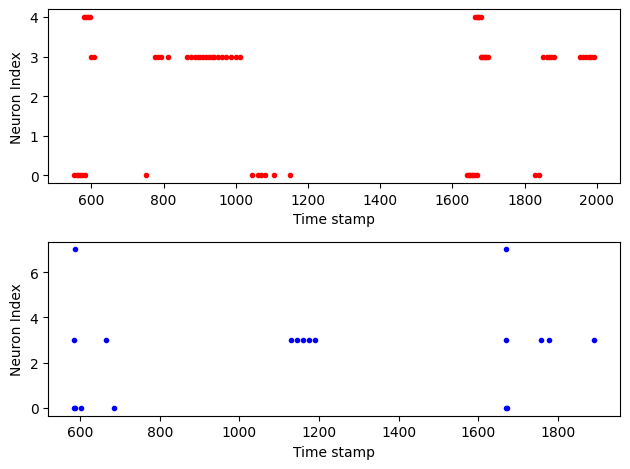

In [26]:
subplot(211)
plot(S1_SA.t/ms, S1_SA.i,'.r') ###raster plot of the 8 SA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('Neuron Index')
subplot(212)
plot(S2_RA.t/ms, S2_RA.i,'.b')###raster plot of the 8 RA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('Neuron Index')

# Fit the plots within the subplots
tight_layout()


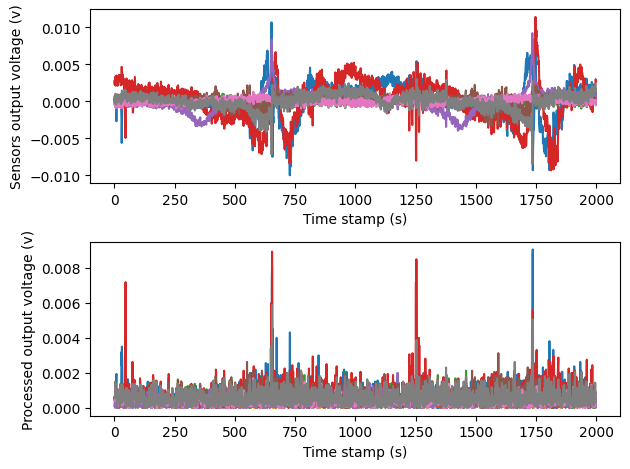

In [43]:
plt.subplot(211)
plt.plot(li[0])
plt.xlabel('Time stamp (s)')  # The time axis can be normalized between 0 and 1 second
plt.ylabel('Sensors output voltage (v)')

plt.subplot(212)
plt.plot(abs(np.diff(li[0], axis=0)))
plt.xlabel('Time stamp (s)')  # The time axis can be normalized between 0 and 1 second
plt.ylabel('Processed output voltage (v)')
plt.tight_layout()  # Plot the absolute derivative of the tactile signal (corresponds to the RA-I)
plt.show()